*  Patel Samarth Rajeshkumar (B21CS057)
*  Pappusani Sai Kiran Reddy (B21CS056)
*  Ved Brahmbhatt            (B21EE075)

# Importing Dataset

In [ ]:
!pip install -q kaggle

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"sarcasam7","key":"1a81cdad144bbce7e3a1374dcb42c13f"}'}

In [ ]:
!mkdir ~/.kaggle

In [ ]:
!cp kaggle.json ~/.kaggle/

In [ ]:
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d tawsifurrahman/covid19-radiography-database

100% 778M/778M [00:34<00:00, 26.6MB/s]
100% 778M/778M [00:34<00:00, 23.7MB/s]


In [ ]:
!unzip /content/covid19-radiography-database.zip

Streaming output truncated to the last 5000 lines.
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7921.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7922.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7923.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7924.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7925.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7926.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7927.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7928.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7929.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-793.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7930.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7931.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7932.png  
 

# Importing Necessary Libraries

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import sys
import seaborn as sns
from tqdm import tqdm
import IPython
import numpy as np
import wave
from sklearn.cluster import KMeans
import os
from PIL import Image
from numpy import asarray
import cv2
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score,f1_score,roc_auc_score, recall_score, precision_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import *
from matplotlib import pyplot
from xgboost.sklearn import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
import torch
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from torchvision.datasets import ImageFolder
from torchvision.datasets.folder import IMG_EXTENSIONS, default_loader
import torch.nn as nn
import torch.optim as optim

# Organizing the data for Deep Learning Models

In [ ]:
covid_path = '/content/COVID-19_Radiography_Dataset/COVID/images'
normal_path = '/content/COVID-19_Radiography_Dataset/Normal/images'

In [ ]:
covid_masked_path = '/content/COVID-19_Radiography_Dataset/COVID/masks'
normal_masked_path = '/content/COVID-19_Radiography_Dataset/Normal/masks'

In [ ]:
print("Number of images for covid positive are ", len(list(os.listdir(covid_path))))
print("Number of images for Normal are ", len(list(os.listdir(normal_path))))
print("Number of masked images for covid positive are ", len(list(os.listdir(covid_masked_path))))
print("Number of masked images for covid positive are ", len(list(os.listdir(normal_masked_path))))

Number of images for covid positive are  3616
Number of images for Normal are  10192
Number of masked images for covid positive are  3616
Number of masked images for covid positive are  10192


# Creating Dataset and Dataloader and visaulizing images

In [ ]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, covid_path, normal_path, transform=None):
        """
        Constructor for the CustomDataset class.

        Args:
        - covid_path (str): Path to the directory containing COVID-19 images.
        - normal_path (str): Path to the directory containing normal images.
        - transform (callable, optional): A function/transform that takes in an image and returns a transformed version.
        """
        self.covid_path = covid_path
        self.normal_path = normal_path
        self.transform = transform

        # Get the paths of all COVID-19 and normal images in their respective directories.
        self.covid_images = [os.path.join(covid_path, f) for f in os.listdir(covid_path) if f.endswith('.png') or f.endswith('.jpg')]
        self.normal_images = [os.path.join(normal_path, f) for f in os.listdir(normal_path) if f.endswith('.png') or f.endswith('.jpg')]

    def __getitem__(self, index):
        """
        Gets the image and label at the specified index.

        Args:
        - index (int): Index of the image to retrieve.

        Returns:
        - img (PIL.Image.Image): The image at the specified index.
        - label (int): The label of the image at the specified index (0 if COVID-19, 1 if normal).
        """
        if index < len(self.covid_images):
            img_path = self.covid_images[index]
            label = 0  # COVID-19
        else:
            img_path = self.normal_images[index - len(self.covid_images)]
            label = 1  # Normal

        # Load the image.
        img = Image.open(img_path).convert('RGB')

        # Apply the transformation (if provided).
        if self.transform is not None:
            img = self.transform(img)

        return img, label

    def __len__(self):
        """
        Returns the length of the dataset.

        Returns:
        - (int): The total number of images in the dataset.
        """
        return len(self.covid_images) + len(self.normal_images)

In [ ]:
# Define the image transformations to be applied
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resizes the image to (224, 224)
    transforms.ToTensor(),  # Converts the image to a PyTorch tensor
])

# Create a custom dataset
dataset = CustomDataset(covid_path, normal_path, transform=transform)
"""
Args:
- covid_path (str): Path to the directory containing COVID-19 images.
- normal_path (str): Path to the directory containing normal images.
- transform (callable, optional): A function/transform that takes in an image and returns a transformed version.
"""

# Split the dataset into train and test sets
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])
"""
Args:
- dataset (Dataset): The dataset to be split.
- lengths (sequence): A sequence of integers defining the lengths of the splits to be produced.
"""

# Create data loaders
batch_size = 32
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
"""
Args:
- dataset (Dataset): The dataset to load the data from.
- batch_size (int, optional): How many samples per batch to load.
- shuffle (bool, optional): Set to True to have the data reshuffled at every epoch.
- drop_last (bool, optional): Set to True to drop the last incomplete batch if the dataset size is not divisible by the batch size.
- num_workers (int, optional): How many subprocesses to use for data loading. 
  0 means that the data will be loaded in the main process. 
  Set it to higher numbers (e.g. 2) to speed up data loading if your CPU and memory have more cores to use.
"""

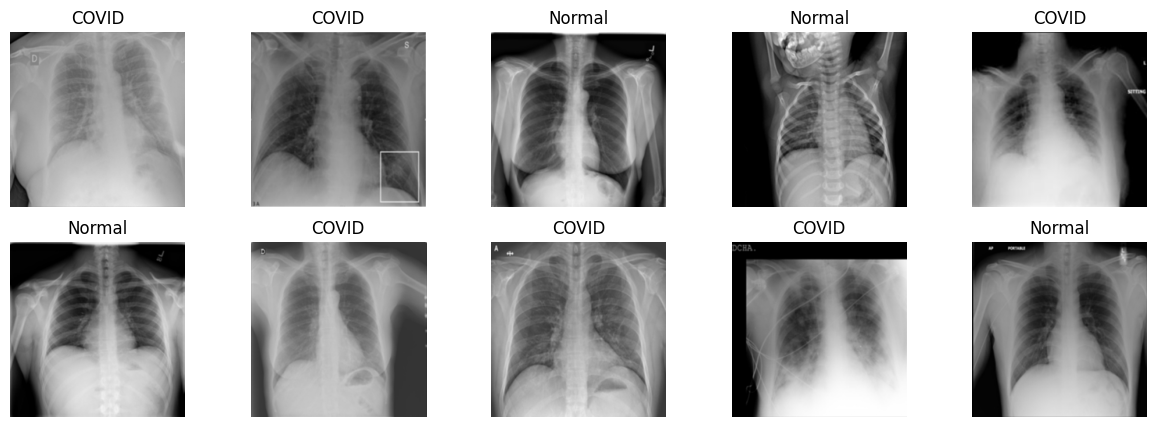

In [ ]:
# Select some random images from the dataset
num_images = 10
random_indices = np.random.choice(len(dataset), size=num_images, replace=False)
random_images = [dataset[i][0] for i in random_indices]
random_labels = [dataset[i][1] for i in random_indices]

# Create a grid of images
fig, axes = plt.subplots(nrows=2, ncols=num_images//2, figsize=(15, 5))

# Display the images
for i in range(num_images):
    ax = axes[i//5, i%5]  # Compute the row and column index of the current subplot
    ax.imshow(random_images[i].permute(1, 2, 0))  # Display the image with channel ordering (C, H, W) -> (H, W, C)
    ax.axis('off')  # Turn off the axis
    ax.set_title('COVID' if random_labels[i] == 0 else 'Normal')  # Set the title based on the label
    
plt.show()

# Applying CNN model from scratch

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torch.nn as nn

# Define a CNN model by subclassing nn.Module
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()  # Call the constructor of nn.Module
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)  # Define a convolutional layer with 3 input channels, 16 output channels, kernel size 3x3, and padding 1
        self.pool = nn.MaxPool2d(2, 2)  # Define a max pooling layer with kernel size 2x2 and stride 2
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)  # Define another convolutional layer with 16 input channels, 32 output channels, kernel size 3x3, and padding 1
        self.fc1 = nn.Linear(32 * 56 * 56, 128)  # Define a fully connected layer with 32 x 56 x 56 input features and 128 output features
        self.fc2 = nn.Linear(128, 2)  # Define the output layer with 128 input features and 2 output features (for COVID and normal classes)

    def forward(self, x):
        x = self.pool(nn.functional.relu(self.conv1(x)))  # Apply the first convolutional layer, ReLU activation function, and max pooling
        x = self.pool(nn.functional.relu(self.conv2(x)))  # Apply the second convolutional layer, ReLU activation function, and max pooling
        x = torch.flatten(x, 1)  # Flatten the output tensor to a 1D tensor
        x = nn.functional.relu(self.fc1(x))  # Apply a ReLU activation function to the output of the fully connected layer
        x = self.fc2(x)  # Apply the output layer
        return x  # Return the output tensor

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [ ]:
# Initialize the model and move it to the GPU
model = Net()  # create a new instance of the Net class
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  # determine the device (GPU or CPU) to use
model = nn.DataParallel(model)  # allow the model to utilize multiple GPUs
model.to(device)  # move the model to the device

# Define the loss function and optimizer
learning_rate = 0.001
criterion = nn.CrossEntropyLoss()  # define the loss function
optimizer = optim.Adam(model.parameters(), lr=learning_rate)  # define the optimizer

# Define variables to keep track of the best validation accuracy and the corresponding model state
best_acc = 0.0  # initialize the best validation accuracy to 0.0
best_state = None  # initialize the best model state to None

# Train the model
for epoch in range(10):
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()  # set the gradients to zero
        outputs = model(inputs)  # forward pass
        loss = criterion(outputs, labels)  # compute the loss
        loss.backward()  # backward pass
        optimizer.step()  # update the weights

        running_loss += loss.item()
        if i % 100 == 99:
            # print the average loss for the last 100 batches
            print(f'Epoch {epoch+1}, batch {i+1}: loss = {running_loss/100:.4f}')
            running_loss = 0.0

    # Validate the model
    correct = 0
    total = 0
    with torch.no_grad():
        for data in test_loader:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    # Update the best model state if the validation accuracy improves
    acc = 100 * correct / total
    if acc > best_acc:
        best_acc = acc
        best_state = model.state_dict()
        torch.save(best_state, 'best_model.pth')  # save the best model state to disk

    # print the validation accuracy for the current epoch
    print(f'Epoch {epoch+1}: validation accuracy = {100 * correct / total:.2f}%')

# Load the best model state
model.load_state_dict(best_state)  # load the best model state from disk

In [ ]:
# Load the best model
model_best = Net()   # initialize a new model
model_best = nn.DataParallel(model_best)  # parallelize the model across multiple GPUs
model_best.load_state_dict(torch.load('/content/drive/MyDrive/models/best_model.pth'))  # load the state of the best model
model_best.to(device)  # move the model to the GPU

# Test the best model
total = 0
correct = 0
y_true_cnn = []  # initialize a list to store the true labels
y_pred_cnn = []  # initialize a list to store the predicted labels
with torch.no_grad():
    for data in test_loader:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model_best(inputs)
        _, predicted = torch.max(outputs.data, 1)  # get the index of the max log-probability
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        y_true_cnn += labels.cpu().tolist()
        y_pred_cnn += predicted.cpu().tolist()

acc_cnn = 100 * correct / total  # calculate the test accuracy
print(f'Test accuracy of best model: {acc_cnn:.2f}%')
f1_cnn = f1_score(y_true_cnn, y_pred_cnn, average='macro')  # calculate the macro F1 score
print(f'F1 score of best model: {f1_cnn:.2f}')


Test accuracy of best model: 98.99%
F1 score of best model: 0.99


# Applying ResNet18 Model

In [ ]:
model_resnet18 = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=True)
model_resnet18.eval()

Downloading: "https://github.com/pytorch/vision/zipball/v0.10.0" to /root/.cache/torch/hub/v0.10.0.zip
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 291MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

In [ ]:
# Define transformation pipeline for ResNet model input
transform_resnet = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Create a custom dataset for the ResNet model
dataset_resnet = CustomDataset(covid_path, normal_path, transform=transform_resnet)

# Split the dataset into train and test sets with 80:20 ratio
train_size = int(0.8 * len(dataset_resnet))
test_size = len(dataset_resnet) - train_size
train_dataset_resnet, test_dataset_resnet = torch.utils.data.random_split(dataset_resnet, [train_size, test_size])

# Create data loaders for the train and test datasets
batch_size = 32
train_loader_resnet = torch.utils.data.DataLoader(train_dataset_resnet, batch_size=batch_size, shuffle=True)
test_loader_resnet = torch.utils.data.DataLoader(test_dataset_resnet, batch_size=batch_size, shuffle=False)

In [ ]:
# Move the model to the specified device
model_resnet18.to(device)

# Define the loss function and optimizer
learning_rate = 0.001
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_resnet18.parameters(), lr=learning_rate)

# Define variables to keep track of the best validation accuracy and the corresponding model state
best_acc = 0.0
best_state = None

# Train the model for 20 epochs
for epoch in range(20):
    running_loss = 0.0
    # Iterate over the training data in batches
    for i, data in enumerate(train_loader_resnet, 0):
        inputs, labels = data
        # Move the inputs and labels to the specified device
        inputs, labels = inputs.to(device), labels.to(device)
        # Zero the gradients
        optimizer.zero_grad()
        # Forward pass
        outputs = model_resnet18(inputs)
        # Compute the loss
        loss = criterion(outputs, labels)
        # Backward pass
        loss.backward()
        # Update the parameters
        optimizer.step()

        # Print statistics every 100 batches
        running_loss += loss.item()
        if i % 100 == 99:
            print(f'Epoch {epoch+1}, batch {i+1}: loss = {running_loss/100:.4f}')
            running_loss = 0.0

    # Validate the model on the test set
    correct = 0
    total = 0
    with torch.no_grad():
        # Iterate over the test data in batches
        for data in test_loader_resnet:
            inputs, labels = data
            # Move the inputs and labels to the specified device
            inputs, labels = inputs.to(device), labels.to(device)
            # Forward pass
            outputs = model_resnet18(inputs)
            # Compute the predicted labels
            _, predicted = torch.max(outputs.data, 1)
            # Update the total and correct counts
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    # Update the best model state if the validation accuracy improves
    acc = 100 * correct / total
    if acc > best_acc:
        best_acc = acc
        best_state = model_resnet18.state_dict()
        # Save the best model state to a file
        torch.save(best_state, 'best_model_resnet18.pth')

    # Print the validation accuracy for the epoch
    print(f'Epoch {epoch+1}: validation accuracy = {100 * correct / total:.2f}%')

# Load the best model state
model_resnet18.load_state_dict(best_state)

In [ ]:
model_resnet18.load_state_dict(torch.load('/content/drive/MyDrive/models/best_model_resnet18.pth'))
model_resnet18.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
# Test the best model

# Initialize variables for keeping track of accuracy and predictions
total = 0
correct = 0
y_true_resnet18 = [] # True labels
y_pred_resnet18 = [] # Predicted labels

# Evaluate the best model on the test set
with torch.no_grad():
    for data in test_loader_resnet:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model_resnet18(inputs)
        _, predicted = torch.max(outputs.data, 1) # Get the index of the class with the highest probability
        total += labels.size(0)
        correct += (predicted == labels).sum().item() # Count the number of correct predictions
        y_true_resnet18 += labels.cpu().tolist() # Append the true labels to the y_true list
        y_pred_resnet18 += predicted.cpu().tolist() # Append the predicted labels to the y_pred list

# Compute the test accuracy and F1 score
acc_resnet18 = 100 * correct / total
print(f'Test accuracy of best resnet18 model: {acc_resnet18:.2f}%')
f1_resnet18 = f1_score(y_true_resnet18, y_pred_resnet18, average='macro')
print(f'F1 score of best renset18 model: {f1_resnet18:.2f}')

Test accuracy of best resnet18 model: 98.33%
F1 score of best renset18 model: 0.98


# Applying InceptionV3 Model

In [ ]:
model_inceptionv3 = torch.hub.load('pytorch/vision:v0.10.0', 'inception_v3', pretrained=True)
model_inceptionv3.eval()

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth
100%|██████████| 104M/104M [00:00<00:00, 229MB/s] 


Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stri

In [ ]:
transform_inceptionv3 = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Create a custom dataset
dataset_inceptionv3 = CustomDataset(covid_path, normal_path, transform=transform_inceptionv3)

# Split the dataset into train and test sets
train_size = int(0.8 * len(dataset_inceptionv3))
test_size = len(dataset_inceptionv3) - train_size
train_dataset_inceptionv3, test_dataset_inceptionv3 = torch.utils.data.random_split(dataset_inceptionv3, [train_size, test_size])

# Create data loaders
batch_size = 32
train_loader_inceptionv3 = torch.utils.data.DataLoader(train_dataset_inceptionv3, batch_size=batch_size, shuffle=True)
test_loader_inceptionv3 = torch.utils.data.DataLoader(test_dataset_inceptionv3, batch_size=batch_size, shuffle=False)


In [ ]:
model_inceptionv3.to(device)

# Define the loss function and optimizer
learning_rate = 0.001
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_inceptionv3.parameters(), lr=learning_rate)

# Define variables to keep track of the best validation accuracy and the corresponding model state
best_acc = 0.0
best_state = None

# Train the model
for epoch in range(20):
    running_loss = 0.0
    for i, data in enumerate(train_loader_inceptionv3, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model_inceptionv3(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 100 == 99:
            print(f'Epoch {epoch+1}, batch {i+1}: loss = {running_loss/100:.4f}')
            running_loss = 0.0

    # Validate the model
    correct = 0
    total = 0
    with torch.no_grad():
        for data in test_loader_inceptionv3:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model_inceptionv3(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    # Update the best model state if the validation accuracy improves
    acc = 100 * correct / total
    if acc > best_acc:
        best_acc = acc
        best_state = model_inceptionv3.state_dict()
        torch.save(best_state, 'best_model_inceptionv3.pth')

    print(f'Epoch {epoch+1}: validation accuracy = {100 * correct / total:.2f}%')

# Load the best model state
model_inceptionv3.load_state_dict(best_state)

In [ ]:
model_inceptionv3.load_state_dict(torch.load('/content/drive/MyDrive/models/best_model_inceptionv3.pth'))
model_inceptionv3.to(device)

Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stri

In [ ]:
# Test the best model
total = 0
correct = 0
y_true_inceptionv3 = []
y_pred_inceptionv3 = []
with torch.no_grad():
    for data in test_loader_inceptionv3:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model_inceptionv3(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        y_true_inceptionv3 += labels.cpu().tolist()
        y_pred_inceptionv3 += predicted.cpu().tolist()

acc_inceptionv3 = 100 * correct / total
print(f'Test accuracy of best inceptionv3 model: {acc_inceptionv3:.2f}%')
f1_inceptionv3 = f1_score(y_true_inceptionv3, y_pred_inceptionv3, average='macro')
print(f'F1 score of best inceptionv3 model: {f1_inceptionv3:.2f}')

Test accuracy of best inceptionv3 model: 74.87%
F1 score of best inceptionv3 model: 0.43


# Applying VGG11 Model

In [ ]:
model_vgg11 = torch.hub.load('pytorch/vision:v0.10.0', 'vgg11', pretrained=True)
model_vgg11.eval()

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
Downloading: "https://download.pytorch.org/models/vgg11-8a719046.pth" to /root/.cache/torch/hub/checkpoints/vgg11-8a719046.pth
100%|██████████| 507M/507M [00:07<00:00, 73.8MB/s]


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU(inplace=True)
    (13): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): ReLU(inplace=True)
    (15): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
 

In [ ]:
transform_vgg11 = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Create a custom dataset
dataset_vgg11 = CustomDataset(covid_path, normal_path, transform=transform_vgg11)

# Split the dataset into train and test sets
train_size = int(0.8 * len(dataset_vgg11))
test_size = len(dataset_vgg11) - train_size
train_dataset_vgg11, test_dataset_vgg11 = torch.utils.data.random_split(dataset_vgg11, [train_size, test_size])

# Create data loaders
batch_size = 32
train_loader_vgg11 = torch.utils.data.DataLoader(train_dataset_vgg11, batch_size=batch_size, shuffle=True)
test_loader_vgg11 = torch.utils.data.DataLoader(test_dataset_vgg11, batch_size=batch_size, shuffle=False)


In [ ]:
model_vgg11.to(device)

# Define the loss function and optimizer
learning_rate = 0.001
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_vgg11.parameters(), lr=learning_rate)

# Define variables to keep track of the best validation accuracy and the corresponding model state
best_acc = 0.0
best_state = None

# Train the model
for epoch in range(20):
    running_loss = 0.0
    for i, data in enumerate(train_loader_vgg11, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model_vgg11(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 100 == 99:
            print(f'Epoch {epoch+1}, batch {i+1}: loss = {running_loss/100:.4f}')
            running_loss = 0.0

    # Validate the model
    correct = 0
    total = 0
    with torch.no_grad():
        for data in test_loader_vgg11:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model_vgg11(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    # Update the best model state if the validation accuracy improves
    acc = 100 * correct / total
    if acc > best_acc:
        best_acc = acc
        best_state = model_vgg11.state_dict()
        torch.save(best_state, 'best_model_vgg_11.pth')

    print(f'Epoch {epoch+1}: validation accuracy = {100 * correct / total:.2f}%')

# Load the best model state
model_vgg11.load_state_dict(best_state)

In [ ]:
model_vgg11.load_state_dict(torch.load('/content/drive/MyDrive/models/best_model_vgg_11.pth'))
model_vgg11.to(device)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU(inplace=True)
    (13): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): ReLU(inplace=True)
    (15): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
 

In [ ]:
# Test the best model
total = 0
correct = 0
y_true_vgg11 = []
y_pred_vgg11 = []
with torch.no_grad():
    for data in test_loader_vgg11:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model_vgg11(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        y_true_vgg11 += labels.cpu().tolist()
        y_pred_vgg11 += predicted.cpu().tolist()

acc_vgg11 = 100 * correct / total
print(f'Test accuracy of best vgg11 model: {acc_vgg11:.2f}%')
f1_vgg11 = f1_score(y_true_vgg11, y_pred_vgg11, average='macro')
print(f'F1 score of best vgg11 model: {f1_vgg11:.2f}')

Test accuracy of best vgg11 model: 98.55%
F1 score of best vgg11 model: 0.98


# Applying AlexNet Model

In [ ]:
model_alexnet = torch.hub.load('pytorch/vision:v0.10.0', 'alexnet', pretrained=True)
model_alexnet.eval()

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:14<00:00, 16.5MB/s]


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [ ]:
transform_alexnet = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Create a custom dataset
dataset_alexnet = CustomDataset(covid_path, normal_path, transform=transform_alexnet)

# Split the dataset into train and test sets
train_size = int(0.8 * len(dataset_alexnet))
test_size = len(dataset_alexnet) - train_size
train_dataset_alexnet, test_dataset_alexnet = torch.utils.data.random_split(dataset_alexnet, [train_size, test_size])

# Create data loaders
batch_size = 32
train_loader_alexnet = torch.utils.data.DataLoader(train_dataset_alexnet, batch_size=batch_size, shuffle=True)
test_loader_alexnet = torch.utils.data.DataLoader(test_dataset_alexnet, batch_size=batch_size, shuffle=False)


In [ ]:
model_alexnet.to(device)

# Define the loss function and optimizer
learning_rate = 0.001
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_alexnet.parameters(), lr=learning_rate)

# Define variables to keep track of the best validation accuracy and the corresponding model state
best_acc = 0.0
best_state = None

# Train the model
for epoch in range(20):
    running_loss = 0.0
    for i, data in enumerate(train_loader_alexnet, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model_alexnet(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 100 == 99:
            print(f'Epoch {epoch+1}, batch {i+1}: loss = {running_loss/100:.4f}')
            running_loss = 0.0

    # Validate the model
    correct = 0
    total = 0
    with torch.no_grad():
        for data in test_loader_alexnet:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model_alexnet(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    # Update the best model state if the validation accuracy improves
    acc = 100 * correct / total
    if acc > best_acc:
        best_acc = acc
        best_state = model_alexnet.state_dict()
        torch.save(best_state, 'best_model_alexnet.pth')

    print(f'Epoch {epoch+1}: validation accuracy = {100 * correct / total:.2f}%')

# Load the best model state
model_alexnet.load_state_dict(best_state)

In [ ]:
model_alexnet.load_state_dict(torch.load('/content/drive/MyDrive/models/best_model_alexnet.pth'))
model_alexnet.to(device)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [ ]:
# Test the best model
total = 0
correct = 0
y_true_alexnet = []
y_pred_alexnet = []
with torch.no_grad():
    for data in test_loader_alexnet:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model_alexnet(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        y_true_alexnet += labels.cpu().tolist()
        y_pred_alexnet += predicted.cpu().tolist()

acc_alexnet = 100 * correct / total
print(f'Test accuracy of best alexnet model: {acc_alexnet:.2f}%')
f1_alexnet = f1_score(y_true_alexnet, y_pred_alexnet, average='macro')
print(f'F1 score of best alexnet model: {f1_alexnet:.2f}')

Test accuracy of best alexnet model: 96.81%
F1 score of best alexnet model: 0.96


# Comparing all deep learning models

In [ ]:
y_pred_model = {'resnet18':y_pred_resnet18, 'vgg11':y_pred_vgg11, 'alexnet':y_pred_alexnet, 'inceptionv3':y_pred_inceptionv3, 'cnn':y_pred_cnn}
y_true_model = {'resnet18':y_true_resnet18, 'vgg11':y_true_vgg11, 'alexnet':y_true_alexnet, 'inceptionv3':y_true_inceptionv3, 'cnn':y_true_cnn}

In [ ]:
models = ['resnet18', 'vgg11', 'alexnet', 'inceptionv3', 'cnn']
results = pd.DataFrame(columns=['Model', 'Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC AUC'])

for model in models:
    y_pred = y_pred_model[model]
    y_true = y_true_model[model]
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    roc_auc = roc_auc_score(y_true, y_pred)
    row = pd.DataFrame({'Model': model, 'Accuracy': accuracy, 'Precision': precision, 'Recall': recall, 'F1 Score': f1, 'ROC AUC': roc_auc}, index=[0])
    results = pd.concat([results, row], ignore_index=True)

In [ ]:
results

,Model,Accuracy,Precision,Recall,F1 Score,ROC AUC
0,resnet18,0.983345,0.982524,0.995084,0.988764,0.972817
1,vgg11,0.985518,0.987366,0.993157,0.990253,0.978422
2,alexnet,0.968139,0.989179,0.968223,0.978589,0.968053
3,inceptionv3,0.748733,0.748733,1.000000,0.856315,0.500000
4,cnn,0.989862,0.989226,0.997038,0.993117,0.983574


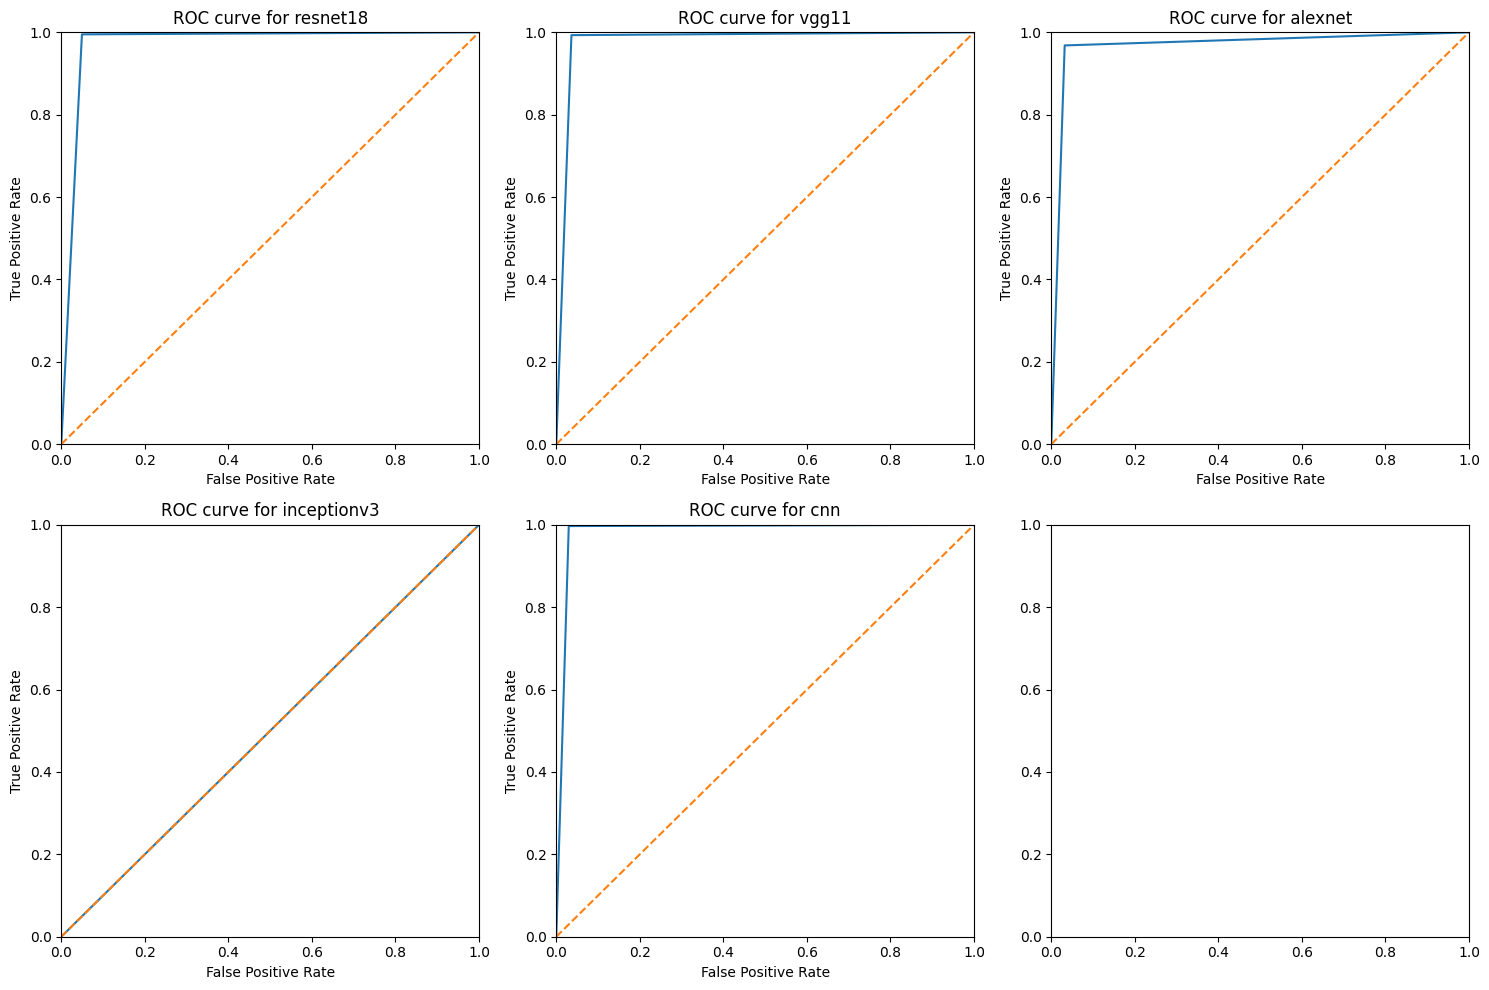

In [ ]:
# Create a grid of subplots
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))

# Loop through each model and its corresponding name and plot the ROC curve
for i, name in enumerate(models):
    fpr, tpr, thresholds = roc_curve(y_true_model[name], y_pred_model[name])
    ax = axes[i//3][i%3]
    ax.plot(fpr, tpr)
    ax.plot([0, 1], [0, 1], linestyle='--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.0])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title(f"ROC curve for {name}")

plt.tight_layout()
plt.show()

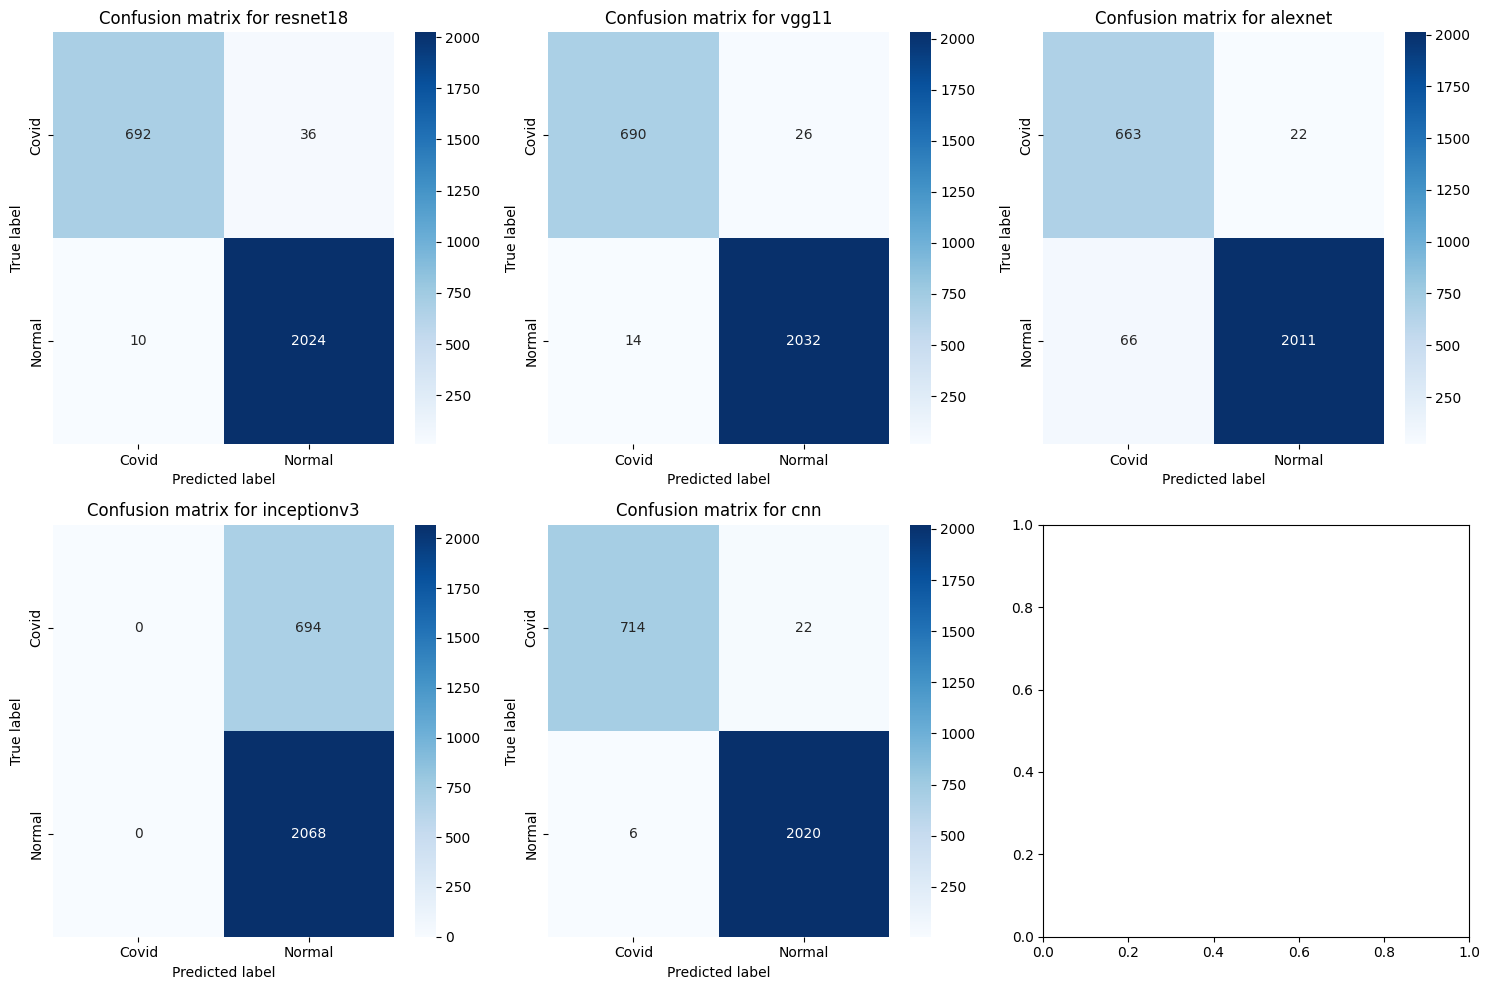

In [ ]:
class_names = ['Covid', 'Normal']

# Create a grid of subplots
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))

# Loop through each model and its corresponding name and plot the confusion matrix
for i, name in enumerate(models):
    cm = confusion_matrix(y_true_model[name], y_pred_model[name])
    ax = axes[i//3][i%3]
    sns.heatmap(cm, annot=True, fmt='g', cmap=plt.cm.Blues, ax=ax, xticklabels=class_names, yticklabels=class_names)
    ax.set_title(f"Confusion matrix for {name}")
    ax.set_xlabel('Predicted label')
    ax.set_ylabel('True label')

plt.tight_layout()
plt.show()

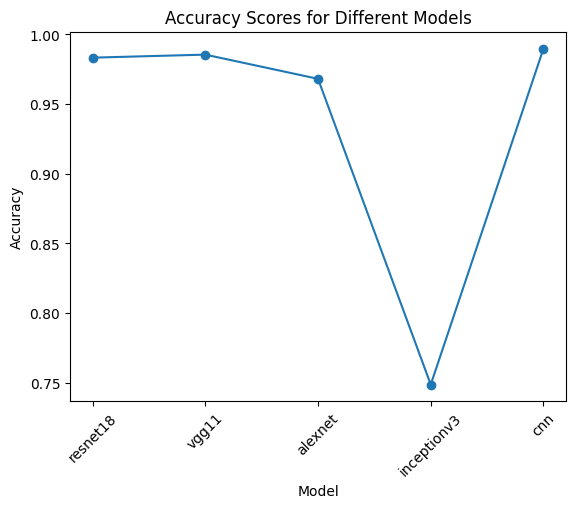

In [ ]:
# Create a list of accuracy scores for each model
accuracy_scores = [accuracy_score(y_true_model[model], y_pred_model[model]) for model in models]

# Create a line plot
plt.plot(models, accuracy_scores, '-o')

# Set the axis labels and title
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Accuracy Scores for Different Models')

# Set the axis ticks and limits
plt.xticks(rotation=45)

# Display the plot
plt.show()

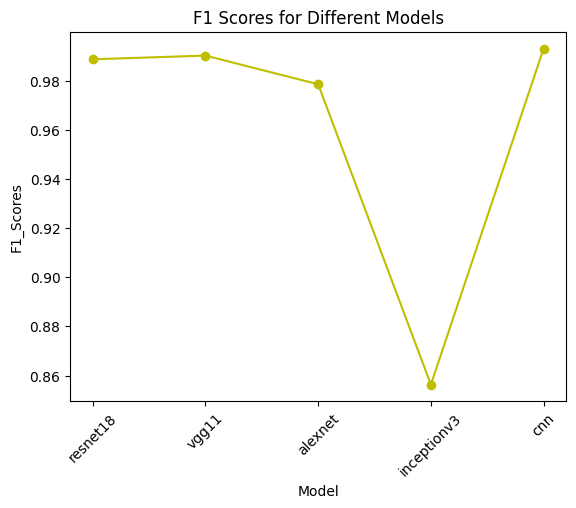

In [ ]:
# Create a list of accuracy scores for each model
F1_Scores = [f1_score(y_true_model[model], y_pred_model[model]) for model in models]

# Create a line plot
plt.plot(models, F1_Scores, '-o', color='y')

# Set the axis labels and title
plt.xlabel('Model')
plt.ylabel('F1_Scores')
plt.title('F1 Scores for Different Models')

# Set the axis ticks and limits
plt.xticks(rotation=45)

# Display the plot
plt.show()

# Applying PCA to one image to reduce dimensions and check the transformed image

In [ ]:
dic={}

In [ ]:
c=0
lst=list(os.listdir(covid_path))
for i in tqdm(range(len(list(os.listdir(covid_path))))):
  dic[c]=covid_path + '/' + lst[i]
  c+=1

100%|██████████| 3616/3616 [00:00<00:00, 962592.24it/s]


In [ ]:
dic_normal={}

In [ ]:
c=0
lst=list(os.listdir(normal_path))
for i in tqdm(range(len(list(os.listdir(normal_path))))):
  dic_normal[c]=normal_path+'/'+lst[i]
  c+=1

100%|██████████| 10192/10192 [00:00<00:00, 1357521.32it/s]


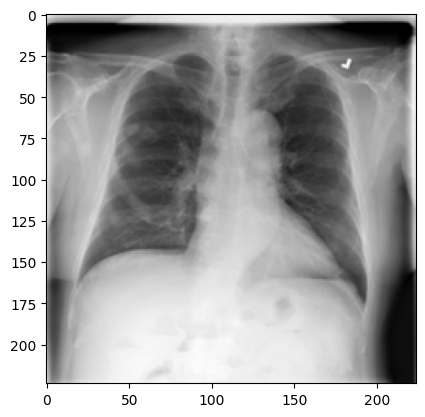

In [ ]:
# Loading the image 
img = cv2.imread(dic_normal[8]) #you can use any image you want.
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
img = cv2.resize(img, dsize=(224,224), interpolation=cv2.INTER_CUBIC)
plt.imshow(img,cmap='gray')

In [ ]:
img.shape

(224, 224)

In [ ]:
pca = PCA(n_components=20)
pca.fit(img)
trans_img = pca.transform(img)

In [ ]:
trans_img.shape

(224, 20)

In [ ]:
trans_img.flatten().shape

(4480,)

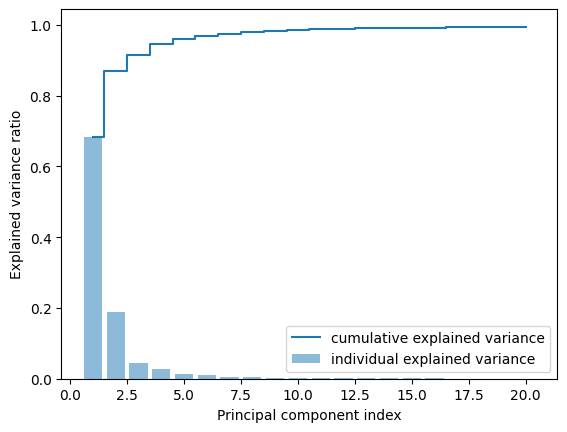

[0.68227671 0.87038425 0.91619675 0.94507203 0.9595605  0.96896537
 0.97456962 0.97911279 0.98250974 0.9854078  0.9873889  0.98883272
 0.99024252 0.99132464 0.9921555  0.9928985  0.99351567 0.99412224
 0.99470795 0.99515044]


In [ ]:
var=(pca.explained_variance_ratio_)
cum_var_exp = np.cumsum(var)
cum_var_exp = np.cumsum(var)

# plot explained variances
plt.bar(range(1,len(var)+1), var, alpha=0.5,
        align='center', label='individual explained variance')
plt.step(range(1,len(var)+1), cum_var_exp, where='mid',
         label='cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.show()

print(cum_var_exp)

Taking 20 PCs to cover 99% variance

In [ ]:
rows = 1
columns = 2
img_transformed = pca.inverse_transform(trans_img)

Text(0.5, 1.0, 'Blurred Image after applying PCA')

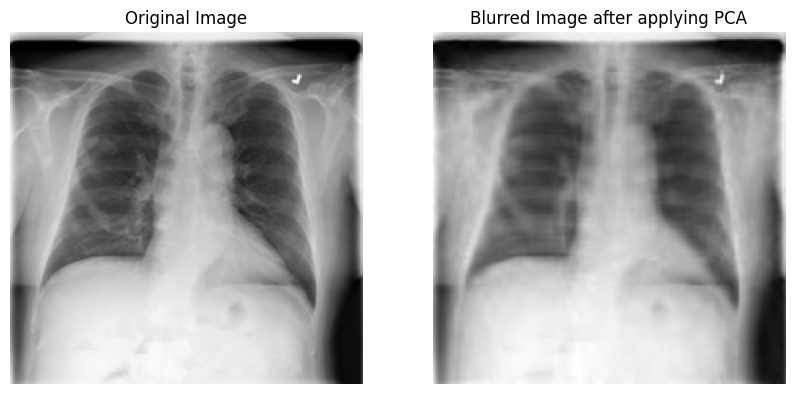

In [ ]:
fig = plt.figure(figsize=(10, 7))
fig.add_subplot(rows, columns, 1)
plt.imshow(img,cmap='gray')
plt.axis('off')
plt.title("Original Image")

fig.add_subplot(rows, columns, 2)
plt.imshow(img_transformed,cmap='gray')
plt.axis('off')
plt.title("Blurred Image after applying PCA")

# Applying PCA over all the images with n_components=20

In [ ]:
dic_keys=list(dic.keys())
array_covid=np.zeros((1,4481))
for i in tqdm(range(len(dic_keys))):
  img = cv2.imread(dic[i]) #you can use any image you want.
  img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  img = cv2.resize(img, dsize=(224,224), interpolation=cv2.INTER_CUBIC)
  pca = PCA(n_components=20)
  pca.fit(img)
  trans_img = pca.transform(img)
  array_covid=np.append(array_covid,np.concatenate((trans_img.flatten(),np.array([1])),axis=0).reshape(1,4481),axis=0)

100%|██████████| 3616/3616 [04:53<00:00, 12.33it/s]


In [ ]:
array_covid.shape

(3617, 4481)

In [ ]:
dic_normal_keys=list(dic_normal.keys())
array_normal=np.zeros((1,4481))
for i in tqdm(range(len(dic_normal_keys))):
  img = cv2.imread(dic_normal[i]) #you can use any image you want.
  img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  img = cv2.resize(img, dsize=(224,224), interpolation=cv2.INTER_CUBIC)
  pca = PCA(n_components=20)
  pca.fit(img)
  trans_img = pca.transform(img)
  array_normal=np.append(array_normal,np.concatenate((trans_img.flatten(),np.array([0])),axis=0).reshape(1,4481),axis=0)

100%|██████████| 10192/10192 [22:49<00:00,  7.44it/s]


In [ ]:
array_normal.shape

(10193, 4481)

# Creating Dataset of PCA transformed images

In [ ]:
data_array=np.concatenate((array_covid,array_normal),axis=0)
data_array.shape

(13810, 4481)

In [ ]:
X=data_array.T[:-1].T
y=data_array.T[-1].T

In [ ]:
X[0].shape

(4480,)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
y_train

array([0., 0., 0., ..., 0., 1., 0.])

# Applying various supervised machine learning models to dataset

In [ ]:
# Define the models
models = {
    'Logistic Regression': LogisticRegression(),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'KNN': KNeighborsClassifier(),
    'SVM': SVC(probability=True),
    'XgBoost': XGBClassifier(),
    'LightGBM': LGBMClassifier()
    
}

best_models = {}
for name, model in models.items():
    clf = model
    clf.fit(X_train, y_train)
    best_models[name] = clf
    print(f"Model for {name} built.")

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Model for Logistic Regression built.
Model for Decision Tree built.
Model for Random Forest built.
Model for KNN built.
Model for SVM built.
Model for XgBoost built.
Model for LightGBM built.


In [ ]:
# Evaluate the best models on the testing set
results = {}
for name, model in best_models.items():
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_prob)
    fpr, tpr, thresholds = roc_curve(y_test, y_prob)
    results[name] = {
        'Accuracy': accuracy,
        'F1 score': f1,
        'Precision': precision,
        'Recall': recall,
        'ROC AUC': roc_auc,
        'FPR': fpr,
        'TPR': tpr,
        'Thresholds': thresholds
    }

# Comparing all supervised machine learning models

In [ ]:
# Create a DataFrame to store the results
df_results = pd.DataFrame(columns=['Model', 'Accuracy', 'F1 score', 'Precision', 'Recall', 'ROC AUC'])

for name, metrics in results.items():
  accuracy = metrics['Accuracy']
  f1 = metrics['F1 score']
  precision = metrics['Precision']
  recall = metrics['Recall']
  roc_auc = metrics['ROC AUC']
  df_results = df_results.append({
    'Model': name,
    'Accuracy': accuracy,
    'F1 score': f1,
    'Precision': precision,
    'Recall': recall,
    'ROC AUC': roc_auc
  }, ignore_index=True)

In [ ]:
df_results

,Model,Accuracy,F1 score,Precision,Recall,ROC AUC
0,Logistic Regression,0.707096,0.381025,0.436842,0.337856,0.714922
1,Decision Tree,0.758508,0.547797,0.547425,0.548168,0.691615
2,Random Forest,0.812817,0.526990,0.808989,0.390773,0.879427
3,KNN,0.803041,0.609195,0.647328,0.575305,0.846046
4,SVM,0.830196,0.615889,0.776860,0.510176,0.875286
5,XgBoost,0.842143,0.657771,0.780261,0.568521,0.909471
6,LightGBM,0.858436,0.694292,0.819188,0.602442,0.929397


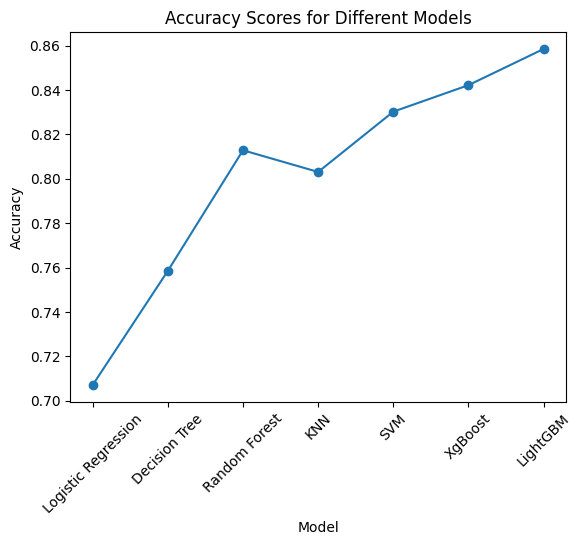

In [ ]:
accs = [0.707096, 0.758508, 0.812817, 0.803041, 0.830196, 0.842143, 0.858436]

model_names = ['Logistic Regression', 'Decision Tree', 'Random Forest', 'KNN','SVM','XgBoost','LightGBM']

# Create a line plot
plt.plot(model_names, accs, '-o')

# Set the axis labels and title
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Accuracy Scores for Different Models')

# Set the axis ticks and limits
plt.xticks(rotation=45)

# Display the plot
plt.show()

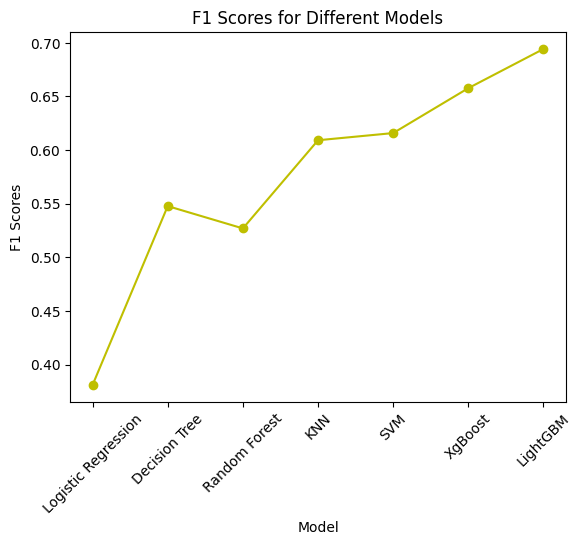

In [ ]:
f1_score = [0.381025, 0.547797, 0.526990, 0.609195, 0.615889, 0.657771, 0.694292]

model_names = ['Logistic Regression', 'Decision Tree', 'Random Forest', 'KNN','SVM','XgBoost','LightGBM']

# Create a line plot
plt.plot(model_names, f1_score, '-o', color='y')

# Set the axis labels and title
plt.xlabel('Model')
plt.ylabel('F1 Scores')
plt.title('F1 Scores for Different Models')

# Set the axis ticks and limits
plt.xticks(rotation=45)

# Display the plot
plt.show()

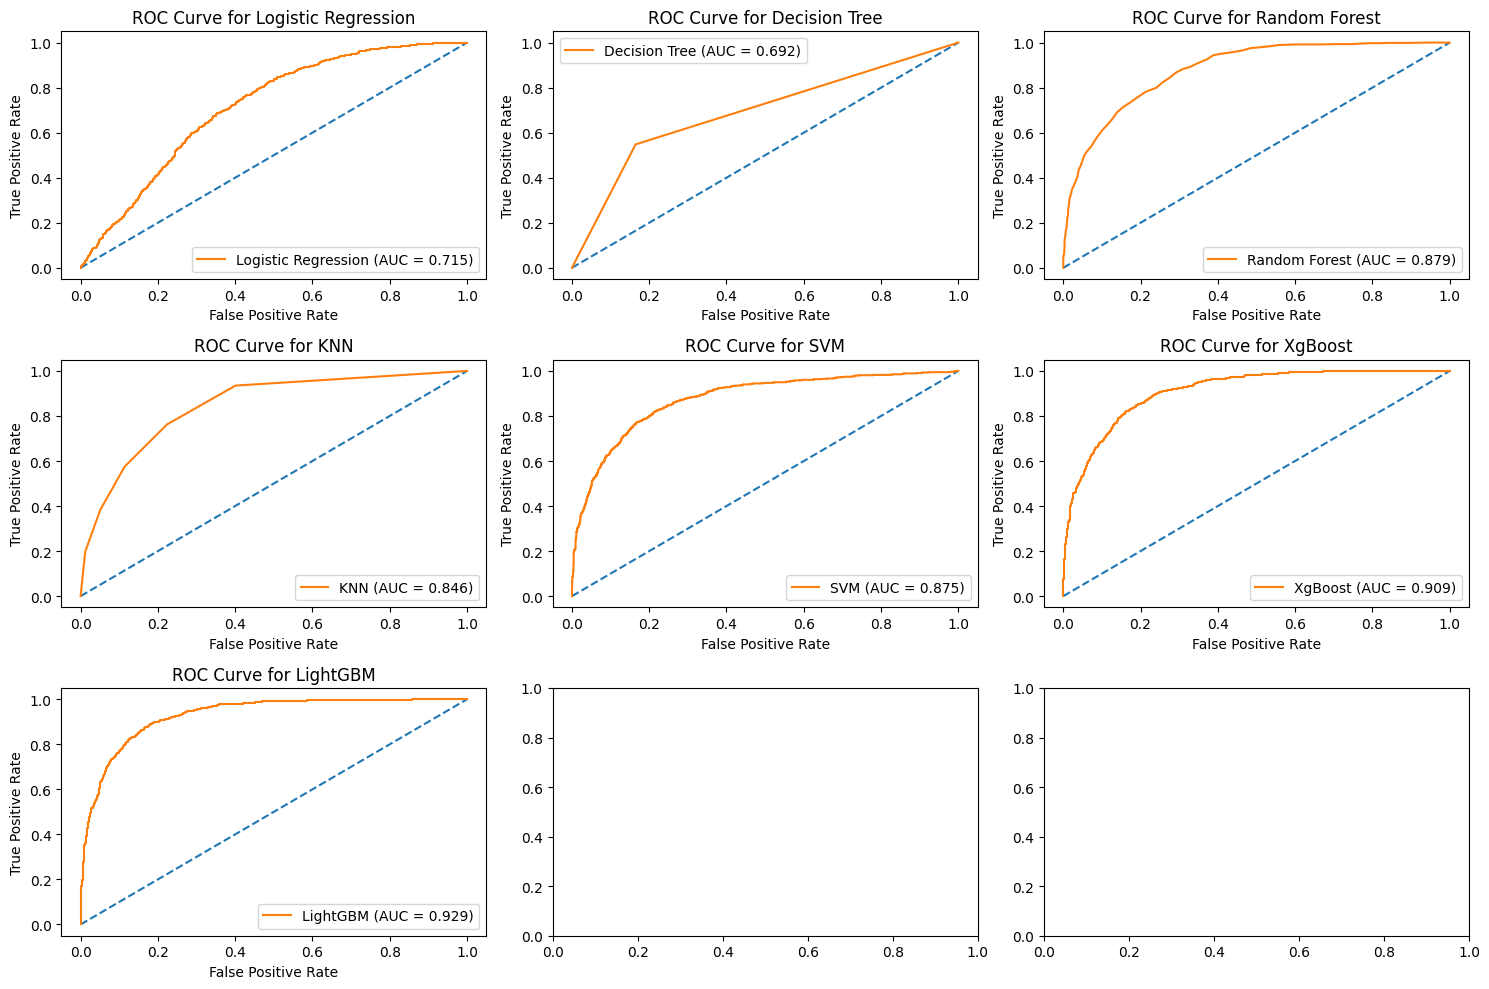

In [ ]:
# Create a grid of subplots for ROC curves
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15,10))

# Plot ROC curves for each model on a separate subplot
for ax, (name, metrics) in zip(axes.flat, results.items()):
  fpr = metrics['FPR']
  tpr = metrics['TPR']
  roc_auc = metrics['ROC AUC']
  ax.plot([0, 1], [0, 1], linestyle='--')
  ax.plot(fpr, tpr, label=f"{name} (AUC = {roc_auc:.3f})")
  ax.set_xlabel('False Positive Rate')
  ax.set_ylabel('True Positive Rate')
  ax.set_title(f'ROC Curve for {name}')
  ax.legend()
# Adjust spacing between subplots
plt.tight_layout()
# Show the plot
plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix

class_names = ['Covid', 'Normal']

# Define the models and their names
models_ = [best_models['Logistic Regression'],
          best_models['Decision Tree'],
          best_models['Random Forest'],
          best_models['KNN'],
          best_models['SVM'],
          best_models['XgBoost'],
          best_models['LightGBM']]
model_names = ['Logistic Regression', 'Decision Tree', 'Random Forest', 'KNN','SVM','XgBoost','LightGBM']

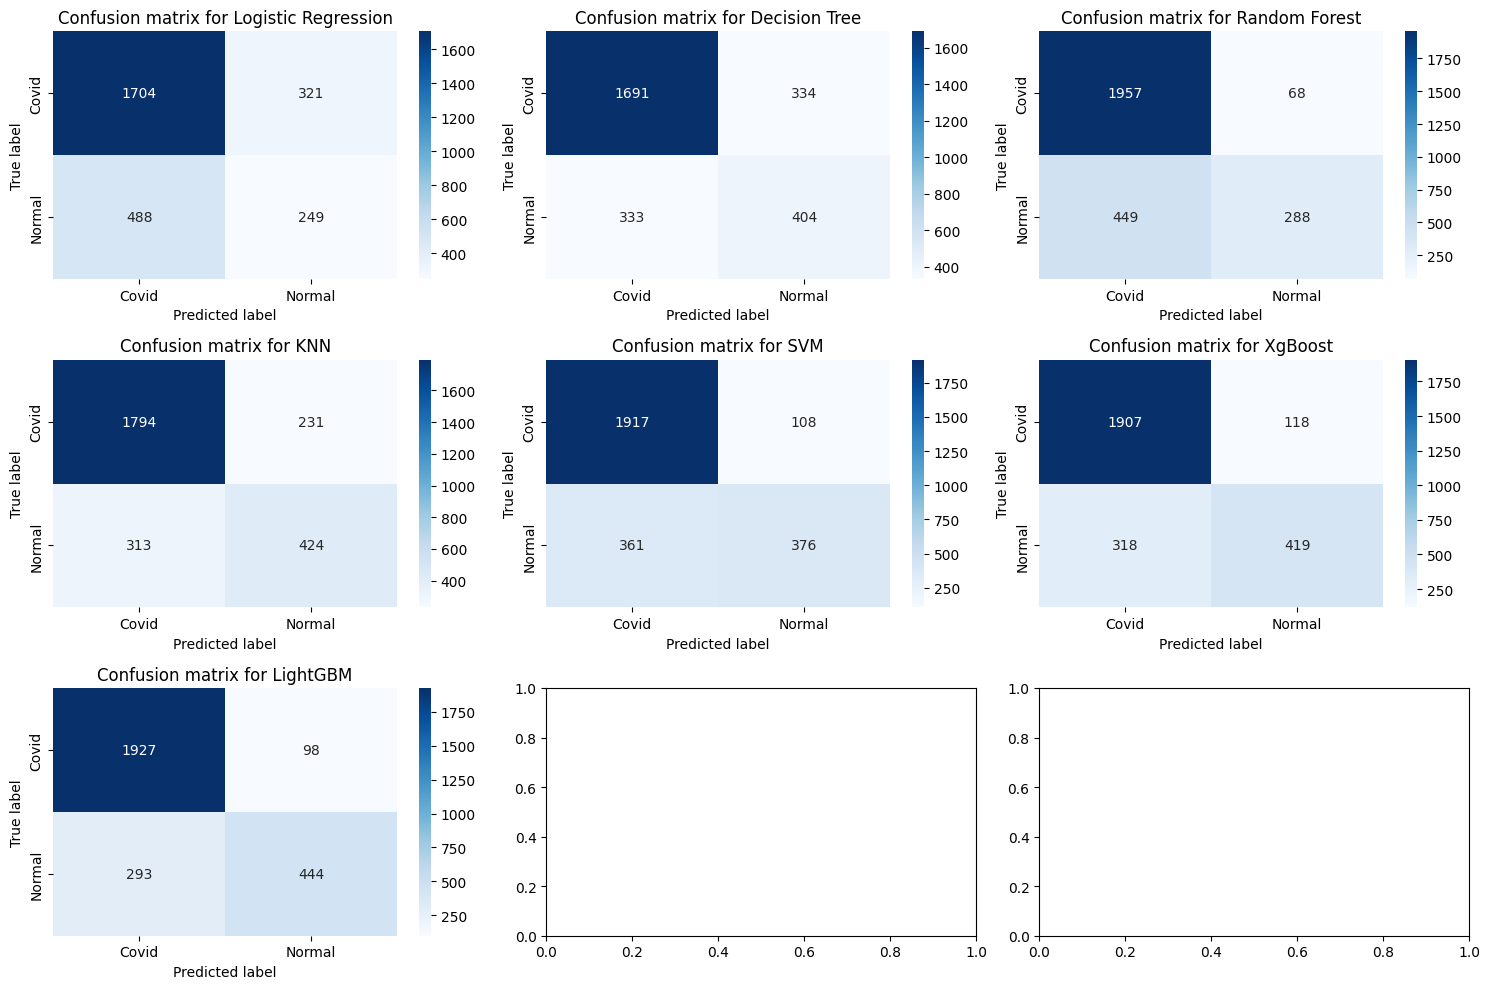

In [ ]:
# Create a grid of subplots
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 10))

# Loop through each model and its corresponding name and plot the confusion matrix
for i, (name, model) in enumerate(zip(model_names, models_)):
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    ax = axes[i//3][i%3]
    sns.heatmap(cm, annot=True, fmt='g', cmap=plt.cm.Blues, ax=ax, xticklabels=class_names, yticklabels=class_names)
    ax.set_title(f"Confusion matrix for {name}")
    ax.set_xlabel('Predicted label')
    ax.set_ylabel('True label')

plt.tight_layout()
plt.show()

# Deep Learning models were trained here


https://colab.research.google.com/drive/1q7NaRgD59VPFlT-Qe07Vy-yZ-KFqiqft?usp=sharing

https://colab.research.google.com/drive/1W9X_CYbbLW-g-MNYWx1OIH79m2k2QkS8?usp=sharing

Drive link for all the best models downloaded

https://drive.google.com/drive/folders/1GAfkh404fPgB2MAA9u00U4wISszhUoyp?usp=sharing